# Protfolio Selection Using RankNet DNN

Stock selection is a very important topic for portfolio management. In this article, we are trying to use RankNet to select the stocks in Canadian stock market.

In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from stock_rv_ranker.layers.ranknet import *
from stock_rv_ranker.model.ranknet_model import RankNet_Model
import tensorflow as tf
import keras_tuner as kt
import time_series_transform as tst
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from stock_rv_ranker.metrics.ranknet import ndcg_at_k
from stock_rv_ranker.utils.preprocess import Batch_Dataset
from stock_rv_ranker.utils.inference import score_to_rank
from sklearn.preprocessing import StandardScaler
from time_series_transform import tfDataset_adopter

In [2]:
df = pd.read_parquet(r"C:\Users\Allen Chiang\Documents\Studio\medium-articles\portfolio_selection_rank_net\RankNet_for_Portfolio_Part_I\data\tsx.parquet")

In [3]:
lengthSymbol = len(df.symbol.unique())

In [4]:
MyStrategy = ta.Strategy(
    name="sta",
    ta=[
        {"kind": "ohlc4"},
        {"kind": "kurtosis", "close": "Volume", "length": 10},
        {"kind": "ema", "length": 15},
        {"kind": "donchian", "lower_length": 10, "upper_length": 15},
        {"kind": "macd"},
        {"kind": "rsi"},
        {"kind":"efi"},
        {"kind":"cmf"},
        {"kind":"chop"},
        {"kind":"midprice"}
    ]
)

In [5]:
tdf = tst.Stock_Transformer.from_pandas(df,'Date','symbol')
tdf = tdf.get_technial_indicator(MyStrategy,n_jobs = 4)
featureList = [
    'Close',
    'High',
    'Low',
    'Open',
    'DCL_10_15',
    'DCM_10_15', 
    'DCU_10_15',
    'MACD_12_26_9', 
    'KURT_10',
    'MACDh_12_26_9',
    'EMA_15',
    'MACDs_12_26_9', 
    'EFI_13',
    'CMF_20',
    'OHLC4',
    'CHOP_14_1_100',
    'MIDPRICE_2',
    'RSI_14'
]
tdf = tdf.make_lag(featureList,1,'_lag_')
tdf = tdf.make_lag(featureList,2,'_lag_')
tdf = tdf.make_lag(featureList,3,'_lag_')
tdf = tdf.make_lead('Close',2,'_lead_')
df = tdf.to_pandas()
df = df.dropna()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   32.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   41.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:  1.6min finished


In [6]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock_Splits', 'Broker', 'insertId', 'OHLC4', 'KURT_10', 'EMA_15',
       'DCL_10_15', 'DCM_10_15', 'DCU_10_15', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'RSI_14', 'EFI_13', 'CMF_20', 'CHOP_14_1_100',
       'MIDPRICE_2', 'Close_lag_1', 'High_lag_1', 'Low_lag_1', 'Open_lag_1',
       'DCL_10_15_lag_1', 'DCM_10_15_lag_1', 'DCU_10_15_lag_1',
       'MACD_12_26_9_lag_1', 'KURT_10_lag_1', 'MACDh_12_26_9_lag_1',
       'EMA_15_lag_1', 'MACDs_12_26_9_lag_1', 'EFI_13_lag_1', 'CMF_20_lag_1',
       'OHLC4_lag_1', 'CHOP_14_1_100_lag_1', 'MIDPRICE_2_lag_1',
       'RSI_14_lag_1', 'Close_lag_2', 'High_lag_2', 'Low_lag_2', 'Open_lag_2',
       'DCL_10_15_lag_2', 'DCM_10_15_lag_2', 'DCU_10_15_lag_2',
       'MACD_12_26_9_lag_2', 'KURT_10_lag_2', 'MACDh_12_26_9_lag_2',
       'EMA_15_lag_2', 'MACDs_12_26_9_lag_2', 'EFI_13_lag_2', 'CMF_20_lag_2',
       'OHLC4_lag_2', 'CHOP_14_1_100_lag_2', 'MIDPRICE_2_lag_2

In [7]:
FEATURELIST = [
    'Close',
    'High',
    'OHLC4',
    'Low',
    'MIDPRICE_2',
    'Open',
    'EMA_15',
    'MACD_12_26_9', 
    'MACDh_12_26_9',
    'MACDs_12_26_9'
]
for i in FEATURELIST:
    df[f'{i}_diff_1'] = df[f'{i}'] - df[f'{i}_lag_1']
    df[f'{i}_diff_2'] = df[f'{i}_lag_1'] - df[f'{i}_lag_2']
    df[f'{i}_diff_3'] = df[f'{i}_lag_2'] - df[f'{i}_lag_3']

In [8]:
df = df[df['Date'].astype(str) > '2017-02-01']
df['profit']  = (df['Close_lead_2'] - df['Close'])
df['rank'] = df.groupby('Date').profit.rank("dense", ascending=True)

In [9]:
df.MACDs_12_26_9.describe()

count    71366.000000
mean         0.443879
std          4.477143
min        -89.349806
25%         -0.142313
50%          0.094049
75%          0.485466
max         94.807155
Name: MACDs_12_26_9, dtype: float64

In [10]:
import gc
gc.collect()

870

In [11]:
train = df[df['Date'].astype(str) < '2021-06-15']
test = df[df['Date'].astype(str) > '2021-06-30']
val = df[df['Date'].astype(str)>='2021-06-15']
val = val[val['Date'].astype(str)<='2021-06-30']

<AxesSubplot:>

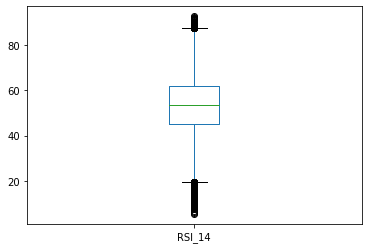

In [12]:
train.RSI_14.plot.box()

In [13]:
for i in train.columns:
    print(i)

Date
Open
High
Low
Close
Volume
Dividends
Stock_Splits
Broker
insertId
OHLC4
KURT_10
EMA_15
DCL_10_15
DCM_10_15
DCU_10_15
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
RSI_14
EFI_13
CMF_20
CHOP_14_1_100
MIDPRICE_2
Close_lag_1
High_lag_1
Low_lag_1
Open_lag_1
DCL_10_15_lag_1
DCM_10_15_lag_1
DCU_10_15_lag_1
MACD_12_26_9_lag_1
KURT_10_lag_1
MACDh_12_26_9_lag_1
EMA_15_lag_1
MACDs_12_26_9_lag_1
EFI_13_lag_1
CMF_20_lag_1
OHLC4_lag_1
CHOP_14_1_100_lag_1
MIDPRICE_2_lag_1
RSI_14_lag_1
Close_lag_2
High_lag_2
Low_lag_2
Open_lag_2
DCL_10_15_lag_2
DCM_10_15_lag_2
DCU_10_15_lag_2
MACD_12_26_9_lag_2
KURT_10_lag_2
MACDh_12_26_9_lag_2
EMA_15_lag_2
MACDs_12_26_9_lag_2
EFI_13_lag_2
CMF_20_lag_2
OHLC4_lag_2
CHOP_14_1_100_lag_2
MIDPRICE_2_lag_2
RSI_14_lag_2
Close_lag_3
High_lag_3
Low_lag_3
Open_lag_3
DCL_10_15_lag_3
DCM_10_15_lag_3
DCU_10_15_lag_3
MACD_12_26_9_lag_3
KURT_10_lag_3
MACDh_12_26_9_lag_3
EMA_15_lag_3
MACDs_12_26_9_lag_3
EFI_13_lag_3
CMF_20_lag_3
OHLC4_lag_3
CHOP_14_1_100_lag_3
MIDPRICE_2_lag_3
RSI_14

In [14]:
FEATURE_LIST = ['Open','High','Close','Low','MIDPRICE_2','OHLC4','DCL_10_15', 'DCM_10_15', 'DCU_10_15']
for i in [[f'{i}_diff_1',f'{i}_diff_2',f'{i}_diff_3'] for i in FEATURELIST]:
    for j in i:
        FEATURE_LIST.append(j)
FEATURE_LIST +=['RSI_14','RSI_14_lag_1','RSI_14_lag_2']

In [15]:
bdc = Batch_Dataset()
xi,xj,y,indexList = bdc.create_numpy_dataset(train,FEATURE_LIST)
val_xi,val_xj,val_y,val_indexList = bdc.create_numpy_dataset(val,FEATURE_LIST)

In [23]:
trainDataset = tf.data.Dataset.from_tensor_slices(({'xi':xi,'xj':xj},y)).batch(lengthSymbol).repeat()
valDataset = tf.data.Dataset.from_tensor_slices(({'xi':val_xi,'xj':val_xj},val_y)).batch(len(val_xj)).repeat().cache()

In [17]:
def create_model(hp):
    lr = hp.Float('lr',1e-2,0.1,1e-3)
    encodeLayers = hp.Int('encodLayers',1,3)
    
    data_input_xi = tf.keras.Input(len(FEATURE_LIST),name='xi')
    data_input_xj = tf.keras.Input(len(FEATURE_LIST),name='xj')
    
    encodeXi = tf.keras.layers.Dense(100,'relu')(data_input_xi)
    encodeXj = tf.keras.layers.Dense(100,'relu')(data_input_xj)
    
    for i in range(encodeLayers):
        outputDim = hp.Int(f'outDim_{i+1}',10,25)
        activationChoice = hp.Choice(f'activation_{i+1}',values=['relu','tanh'])
        encodeXi = tf.keras.layers.Dense(outputDim,activation = activationChoice)(encodeXi)
        encodeXj = tf.keras.layers.Dense(outputDim,activation = activationChoice)(encodeXj)
        
    ranknet = RankNet_Head()([encodeXi,encodeXj])
    model = RankNet_Model(
        inputs={'xi':data_input_xi,'xj':data_input_xj}, 
        outputs=ranknet, name="rankNet_model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss = tf.keras.losses.CategoricalHinge())
    return model

In [18]:
import os

In [19]:
gc.collect()

140

In [20]:
pd.DataFrame(xi).describe()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
count,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,...,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06,2.127396e+06
mean,6.392190e+01,6.454120e+01,6.393090e+01,6.329940e+01,6.389949e+01,6.392335e+01,6.147315e+01,6.394953e+01,6.642591e+01,3.488386e-02,...,-3.354420e-04,3.281547e-04,3.014398e-04,2.772742e-04,-4.553177e-04,-5.373563e-04,-6.127163e-04,5.344610e+01,5.344134e+01,5.343665e+01
std,1.236326e+02,1.251692e+02,1.236222e+02,1.220392e+02,1.235367e+02,1.236109e+02,1.181227e+02,1.234382e+02,1.288779e+02,2.831034e+00,...,3.328265e-01,2.305903e-01,2.304791e-01,2.304402e-01,2.104188e-01,2.100956e-01,2.098343e-01,1.238375e+01,1.238620e+01,1.238912e+01
min,3.300000e-01,3.500000e-01,3.200000e-01,3.000000e-01,3.250000e-01,3.325000e-01,3.000000e-01,3.450000e-01,3.900000e-01,-3.902600e+02,...,-3.040286e+01,-2.482234e+01,-2.482234e+01,-2.482234e+01,-1.179247e+01,-1.179247e+01,-1.179247e+01,5.354313e+00,5.354313e+00,5.354313e+00
25%,2.467317e+01,2.490000e+01,2.466000e+01,2.447229e+01,2.465491e+01,2.465820e+01,2.388000e+01,2.466550e+01,2.553443e+01,-2.354050e-01,...,-3.668380e-02,-2.581642e-02,-2.579174e-02,-2.577430e-02,-2.467073e-02,-2.466184e-02,-2.465240e-02,4.509356e+01,4.508952e+01,4.508398e+01
50%,4.192719e+01,4.231290e+01,4.193963e+01,4.156000e+01,4.192825e+01,4.194553e+01,4.040915e+01,4.188450e+01,4.352091e+01,1.000023e-02,...,4.787561e-04,-2.275167e-04,-2.227272e-04,-1.968137e-04,4.660763e-04,4.688941e-04,4.689594e-04,5.362681e+01,5.362028e+01,5.361547e+01
75%,6.825533e+01,6.873750e+01,6.826000e+01,6.782307e+01,6.825559e+01,6.826200e+01,6.623820e+01,6.814144e+01,7.038667e+01,2.950935e-01,...,3.847366e-02,2.442083e-02,2.444063e-02,2.446168e-02,2.608200e-02,2.605611e-02,2.602538e-02,6.215190e+01,6.214908e+01,6.214719e+01
max,1.917280e+03,1.921780e+03,1.914120e+03,1.887720e+03,1.896370e+03,1.905473e+03,1.790050e+03,1.855915e+03,1.921780e+03,1.590200e+02,...,1.748506e+01,1.146173e+01,1.146173e+01,1.146173e+01,9.739907e+00,9.739907e+00,9.739907e+00,9.260382e+01,9.260382e+01,9.260382e+01


In [21]:
byo = kt.BayesianOptimization(
    hypermodel = create_model,
    objective='val_loss',
    max_trials=25,
    directory=os.path.normpath(r'C:\Users\Allen Chiang\Documents\Studio\medium-articles\portfolio_selection_rank_net_v0'),
    num_initial_points=2,
    tune_new_entries=True,
    allow_new_entries=True,
    project_name='v16')

In [24]:
hp = kt.HyperParameters()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
byo.search(    
    x = ({'xi':xi,'xj':xj}),
    y = y,
    batch_size = len(xi),
    steps_per_epoch = 1 ,#len(xj)/lengthSymbol,
    validation_data=valDataset,
    validation_steps=1,
    epochs = 200,
    callbacks=[stop_early]
)

Trial 26 Complete [00h 00m 43s]
val_loss: 0.9659605026245117

Best val_loss So Far: 0.9510167837142944
Total elapsed time: 00h 29m 38s
INFO:tensorflow:Oracle triggered exit


In [27]:
model = byo.get_best_models()[0]

In [28]:
testScore = {}
predictDict = {}
for i in test['Date'].unique():
    tdd = test[test['Date'] == i]
    print(tdd['symbol'])
    test_xi,test_xj,test_y,test_indexList = bdc.create_numpy_dataset(tdd,FEATURE_LIST)
    prd = model.predict({'xi':test_xi,'xj':test_xj})
    scoreDict = score_to_rank(tdd.symbol.unique(),test_indexList,prd)
    scoreList = []
    for j in tdd.set_index('symbol')['profit'].sort_values(ascending=False).index.tolist():
            scoreList.append(scoreDict[j][0])
    predictDict[i] = scoreDict
    testScore[i.strftime("%Y-%m-%d")] = ndcg_at_k(scoreList,10)

1128        XSP.TO
2293        BNS.TO
3450      ATD-A.TO
4611        FSV.TO
5772        UNC.TO
           ...    
68948     RCI-B.TO
70107    BEP-PE.TO
71271       XIC.TO
72436      SHOP.TO
73339       CEF.TO
Name: symbol, Length: 63, dtype: object
1129        XSP.TO
2294        BNS.TO
3451      ATD-A.TO
4612        FSV.TO
5773        UNC.TO
           ...    
68949     RCI-B.TO
70108    BEP-PE.TO
71272       XIC.TO
72437      SHOP.TO
73340       CEF.TO
Name: symbol, Length: 63, dtype: object
1130        XSP.TO
2295        BNS.TO
3452      ATD-A.TO
4613        FSV.TO
5774        UNC.TO
           ...    
68950     RCI-B.TO
70109    BEP-PE.TO
71273       XIC.TO
72438      SHOP.TO
73341       CEF.TO
Name: symbol, Length: 63, dtype: object
1131        XSP.TO
2296        BNS.TO
3453      ATD-A.TO
4614        FSV.TO
5775        UNC.TO
           ...    
68951     RCI-B.TO
70110    BEP-PE.TO
71274       XIC.TO
72439      SHOP.TO
73342       CEF.TO
Name: symbol, Length: 63, dtype: object
1132

ValueError: DataFrame index must be unique for orient='index'.

In [30]:
testScore

{'2021-07-02': 0.897586604150384,
 '2021-07-05': 0.9121857836995053,
 '2021-07-06': 0.7518667789502212,
 '2021-07-07': 0.8231710807823328,
 '2021-07-08': 0.8927691910844026,
 '2021-07-12': 0.7934649159533892,
 '2021-07-13': 0.718291082658381,
 '2021-07-14': 0.690769993004777,
 '2021-07-15': 0.7433211916706823,
 '2021-07-16': 0.8497651754251423,
 '2021-07-19': 0.871374987801535,
 '2021-07-20': 0.8539953019912463,
 '2021-07-21': 0.8948203366082769,
 '2021-07-22': 0.7212630964539417,
 '2021-07-23': 0.8223363492692023,
 '2021-07-26': 0.8417089936949487,
 '2021-07-27': 0.8130359732032896,
 '2021-07-28': 0.7704834023379475,
 '2021-07-29': 0.7856183610692729,
 '2021-07-30': 0.8855368228120462,
 '2021-08-03': 0.887390709721005,
 '2021-08-04': 0.7821414717271482,
 '2021-08-05': 0.9024079876150881,
 '2021-08-06': 0.8004749249087182,
 '2021-08-09': 0.6979980944531196,
 '2021-08-10': 0.8239125884777936,
 '2021-08-11': 0.8542178128617797,
 '2021-08-12': 0.6612070861419898,
 '2021-08-13': 0.65557721

In [31]:
pfDf = pd.DataFrame.from_dict(predictDict).astype(float)

In [32]:
maxSc = pd.DataFrame.from_dict(predictDict).astype(float).idxmax().to_dict()

In [33]:
profitDf = pd.DataFrame()
for i in maxSc:
    profitDf = profitDf.append(test[test.symbol == maxSc[i]][test.Date == i][['Date','symbol','profit']],ignore_index = True)

<ipython-input-33-d4d657a6027a>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [34]:
profitDf

,Date,symbol,profit
0,2021-07-02,SHOP.TO,108.109985
1,2021-07-05,SHOP.TO,84.479980
2,2021-07-06,SHOP.TO,-78.329956
3,2021-07-07,SHOP.TO,-36.420044
4,2021-07-08,SHOP.TO,61.829956
5,2021-07-12,SHOP.TO,-32.199951
6,2021-07-13,SHOP.TO,-85.069946
7,2021-07-14,SHOP.TO,-10.410034
8,2021-07-15,SHOP.TO,60.329956
9,2021-07-16,SHOP.TO,115.309937


,profit
count,30.000000
mean,4.505998
std,64.084110
min,-110.149902
25%,-36.742584
50%,-3.410034
75%,61.454956
max,115.309937


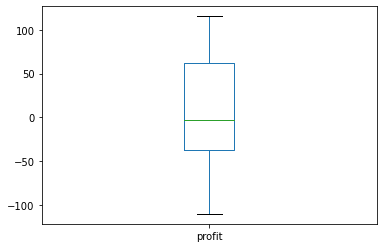

In [35]:
profitDf.profit.plot.box()
profitDf.describe()

In [36]:
profitDict = {}
for i in pfDf:
    profitDict[i]=pfDf[i].sort_values(ascending = False).dropna().head(10).index.tolist()

In [37]:
for i in profitDict.values():
    print(i)

['SHOP.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO', 'UNC.TO', 'CDAY.TO', 'DOL.TO', 'CAR-UN.TO', 'PPL.TO']
['SHOP.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO', 'UNC.TO', 'CDAY.TO', 'DOL.TO', 'CAR-UN.TO', 'PPL.TO']
['SHOP.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO', 'UNC.TO', 'CDAY.TO', 'DOL.TO', 'CAR-UN.TO', 'GIB-A.TO']
['SHOP.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO', 'UNC.TO', 'CDAY.TO', 'DOL.TO', 'PPL.TO', 'GIB-A.TO']
['SHOP.TO', 'MG.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'ATD-A.TO', 'FSV.TO', 'UNC.TO', 'CDAY.TO', 'DOL.TO']
['SHOP.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO', 'UNC.TO', 'FNV.TO', 'CDAY.TO', 'DOL.TO', 'GIB-A.TO']
['SHOP.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO', 'UNC.TO', 'CDAY.TO', 'DOL.TO', 'CAR-UN.TO', 'GIB-A.TO']
['SHOP.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO', 'UNC.TO', 'CDAY.TO', 'DOL.TO', 'GIB-A.TO', 'TD.TO']
['SHOP.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO', 'UNC.TO', 'SU.TO', 'CDAY.TO', 'DOL.TO', 'CAR-UN.TO']
['SHOP.TO', 'MG.TO', 'CSU.TO', 'CP.TO', 'BNS.TO', 'FSV.TO'

In [38]:
profitability = {}
for i in profitDict:
    profitability[i] = 0
    for j in profitDict[i]:
        tmp = test[test['Date'] == i]
        tmp = tmp[tmp['symbol'] == j]
        profitability[i] += float(tmp[['profit']].values[0])

In [39]:
profitability

{datetime.date(2021, 7, 2): 127.90997695922852,
 datetime.date(2021, 7, 5): 100.3099365234375,
 datetime.date(2021, 7, 6): -83.18988800048828,
 datetime.date(2021, 7, 7): -38.73003005981445,
 datetime.date(2021, 7, 8): 84.36991882324219,
 datetime.date(2021, 7, 12): -26.24997329711914,
 datetime.date(2021, 7, 13): -67.47998046875,
 datetime.date(2021, 7, 14): -9.900035858154297,
 datetime.date(2021, 7, 15): 30.009906768798828,
 datetime.date(2021, 7, 16): 126.31000709533691,
 datetime.date(2021, 7, 19): 121.84006118774414,
 datetime.date(2021, 7, 20): 74.63001441955566,
 datetime.date(2021, 7, 21): 119.5999870300293,
 datetime.date(2021, 7, 22): -11.37997055053711,
 datetime.date(2021, 7, 23): -101.04001235961914,
 datetime.date(2021, 7, 26): -28.079978942871094,
 datetime.date(2021, 7, 27): -34.269996643066406,
 datetime.date(2021, 7, 28): -3.0399742126464844,
 datetime.date(2021, 7, 29): 55.779964447021484,
 datetime.date(2021, 7, 30): 111.13002014160156,
 datetime.date(2021, 8, 3): 

In [40]:
np.sum(list(profitability.values()))

573.9800300598145

<AxesSubplot:>

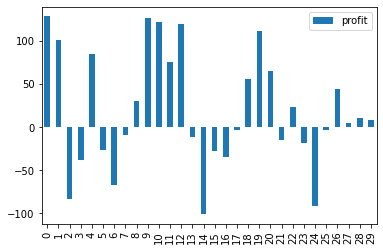

In [41]:
pd.DataFrame({'profit':list(profitability.values())}).plot.bar()

<AxesSubplot:>

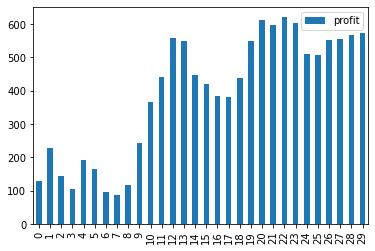

In [42]:
pd.DataFrame({'profit':list(profitability.values())}).cumsum().plot.bar()

<AxesSubplot:>

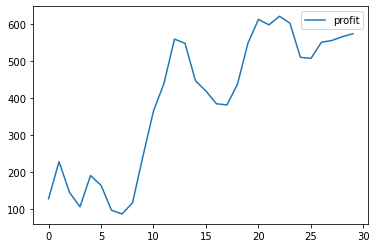

In [43]:
pd.DataFrame({'profit':list(profitability.values())}).cumsum().plot.line()

In [44]:
model.save(r'C:\Users\Allen Chiang\Documents\Studio\medium-articles\portfolio_selection_rank_net\models\RankNet')

INFO:tensorflow:Assets written to: C:\Users\Allen Chiang\Documents\Studio\medium-articles\portfolio_selection_rank_net\models\RankNet\assets
